In [1]:
import starepandas
import pandas
import geopandas
import matplotlib.pyplot as plt
import sqlalchemy
import shapely
import numpy

# Loading countries
We load the countries of the world and create STARE index values representing their cover. 

In [2]:
path = geopandas.datasets.get_path('naturalearth_lowres')
world = geopandas.read_file(path)
n_america = world[world.continent=='North America']

stare = starepandas.stare_from_gdf(n_america, level=7, force_ccw=True)
n_america = starepandas.STAREDataFrame(n_america, stare=stare)

# The trixels are just for visualization
n_america.set_trixels(inplace=True)
n_america.head()

Index(['pop_est', 'continent', 'name', 'iso_a3', 'gdp_md_est', 'geometry'], dtype='object')


pop_est      continent                      name iso_a3  gdp_md_est  \
3    35623680  North America                    Canada    CAN   1674000.0   
4   326625791  North America  United States of America    USA  18560000.0   
16   10646714  North America                     Haiti    HTI     19340.0   
17   10734247  North America            Dominican Rep.    DOM    161900.0   
19     329988  North America                   Bahamas    BHS      9066.0   

                                             geometry  \
3   MULTIPOLYGON (((-122.84000 49.00000, -122.9742...   
4   MULTIPOLYGON (((-122.84000 49.00000, -120.0000...   
16  POLYGON ((-71.71236 19.71446, -71.62487 19.169...   
17  POLYGON ((-71.70830 18.04500, -71.68774 18.316...   
19  MULTIPOLYGON (((-78.98000 26.79000, -78.51000 ...   

                                                stare  \
3   [3035426148847714308, 3062447746611937284, 306...   
4   [3332663724254167043, 3071454945866678276, 307...   
16  [3100869080932941831, 3100904265305030663, 310...   
17  [2506253192631681031, 2506323561375858695, 250...   
19  [3126096275720634375, 3128875841115652103, 313...   

                                              trixels  
3   (POLYGON ((-75.36119395309578 57.6315877704803...  
4   (POLYGON ((-90.00000034377467 35.2643901689254...  
16  (POLYGON ((-72.49080671672886 19.1339374296424...  
17  (POLYGON ((-69.40758227230447 18.0684328436267...  
19  (POLYGON ((-77.359038727403 26.6312970536891, ...

<AxesSubplot:>

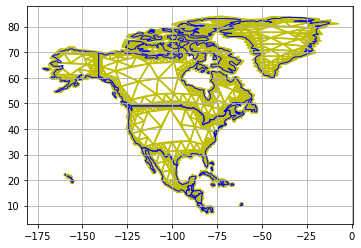

In [3]:
fig, ax = plt.subplots()
ax.grid(True)

n_america.plot(ax=ax, trixels=True, boundary=True, color='y', zorder=0)
n_america.plot(ax=ax, trixels=False, facecolor="none", edgecolor='blue', zorder=1)

# We are creating an catalogue dataframe

folder2catalogue() scans the path for granules, reads stare cover from the sidecar file as well as the timestamps from the metadata and creatse a catalogue dataframe

In [4]:
import starepandas

In [5]:
folder = '/home/griessbaum/MOD09/'
catalogue = starepandas.folder2catalogue(path=folder, 
                             granule_extension='hdf',
                             add_sf=True)
catalogue.head()

Index(['begining', 'ending', 'geom', 'granule_name', 'sidecar_name',
       'stare_cover'],
      dtype='object')


begining              ending  \
0 2019-12-02 00:00:00 2019-12-02 00:05:00   
1 2019-11-13 08:15:00 2019-11-13 08:20:00   
2 2020-09-10 13:20:00 2020-09-10 13:25:00   
3 2005-12-15 21:25:00 2005-12-15 21:30:00   

                                                geom  \
0  POLYGON ((-15.93400 53.20178, -15.93275 53.292...   
1  POLYGON ((24.93397 13.98134, 24.93208 13.96333...   
2  POLYGON ((-49.78107 29.28507, -49.78662 29.195...   
3  POLYGON ((-171.02278 37.52311, -171.02644 37.4...   

                                        granule_name  \
0  /home/griessbaum/MOD09/MOD05_L2.A2019336.0000....   
1  /home/griessbaum/MOD09/MOD09.A2019317.0815.006...   
2  /home/griessbaum/MOD09/MOD05_L2.A2020254.1320....   
3  /home/griessbaum/MOD09/MOD05_L2.A2005349.2125....   

                                        sidecar_name  \
0  /home/griessbaum/MOD09/MOD05_L2.A2019336.0000....   
1  /home/griessbaum/MOD09/MOD09.A2019317.0815.006...   
2  /home/griessbaum/MOD09/MOD05_L2.A2020254.1320....   
3  /home/griessbaum/MOD09/MOD05_L2.A2005349.2125....   

                                         stare_cover  
0  [3614138700964823044, 3616390500778508292, 361...  
1  [4361736239108325380, 4366239838735695876, 437...  
2  [2544533789464330244, 2546785589278015492, 256...  
3  [1157425104234217476, 1173187702930014212, 118...

# Now we use the catalog to find all granules that intersect our ROI

## We can do this with geopandas SF based intersects method

In [6]:
roi_wkt = n_america[n_america.name=='Greenland'].geometry.iloc[0]

cover_intersects = catalogue.intersects(roi_wkt)
granule_subset = catalogue[cover_intersects].granule_name

granule_subset.head()

0    /home/griessbaum/MOD09/MOD05_L2.A2019336.0000....
Name: granule_name, dtype: object

## We can do this with stare_intersects

In [7]:
roi_stare = n_america[n_america.name=='Greenland'].stare.iloc[0]

cover_intersects = catalogue.stare_intersects(roi_stare)
granule_subset = catalogue[cover_intersects].granule_name

msg = 'there are {} granules intersecting the ROI'.format(len(granule_subset))
print(msg)
granule_subset.head()

there are 1 granules intersecting the ROI


0    /home/griessbaum/MOD09/MOD05_L2.A2019336.0000....
Name: granule_name, dtype: object

# Finally, we extract the data from the pre-selected granules that intersects with our ROI

In [8]:
df = pandas.DataFrame()
for granule in granule_subset:
    g = starepandas.read_mod05(granule, sidecar=True)
    intersects = g.stare_intersects(roi_stare)
    msg = '{granule} has {n} intersecting points'.format(granule=granule,
                                                        n=sum(intersects))
    print(msg)
    df = df.append(g[intersects])

/home/griessbaum/MOD09/MOD05_L2.A2019336.0000.061.2019336211522.hdf has 26756 intersecting points


In [9]:
df.head()

lat        lon                stare  Scan_Start_Time  \
55278  59.822590 -43.944996  3630376560299884459     8.493986e+08   
55279  59.800552 -44.052574  3630376364319331947     8.493986e+08   
55280  59.778336 -44.160446  3630446998470491531     8.493986e+08   
55546  59.912483 -43.770641  3630379610335789163     8.493986e+08   
55547  59.891968 -43.872753  3630377324249826827     8.493986e+08   

       Solar_Zenith  Solar_Azimuth  Sensor_Zenith  Sensor_Azimuth  \
55278         13256          -5505           2864            6766   
55279         13253          -5518           2910            6757   
55280         13249          -5532           2957            6748   
55546         13258          -5478           2771            6877   
55547         13255          -5491           2817            6867   

       Water_Vapor_Infrared  
55278                 -9999  
55279                   161  
55280                   166  
55546                   395  
55547                 -9999

# Write to SQL 
We can write the catalogue dataframe to an sql (e.g. sqlite) database. 
From here, we could use STARELite to query the catalogue, or load it back into a STAREDataframe if we need to

In [10]:
db_path = 'data/catalogue.sqlite' 
uri = 'sqlite:///{db_path}'.format(db_path=db_path)
engine = sqlalchemy.create_engine(uri)

catalogue_ewkb = geopandas.io.sql._convert_to_ewkb(catalogue, 'geom', 4326)
catalogue_ewkb.to_sql(name='catalogue', con=engine, if_exists='replace', index=False)

## Load from SQL

In [11]:
db_path = 'data/catalogue.sqlite' 
uri = 'sqlite:///{db_path}'.format(db_path=db_path)
engine = sqlalchemy.create_engine(uri)

In [22]:
cover_intersects = pandas.read_sql(sql='catalogue', con=engine)

# Geometry and STARE are stored in blobs, so we need to deserialize
cover_intersects.stare_cover = cover_intersects.stare_cover.apply(func=numpy.frombuffer, args=('int64',))
cover_intersects.geom = cover_intersects.geom.apply(shapely.wkb.loads, args=(True,))

# We convert the conventional DF to a STAREDataFrame and set the stare column
cover_intersects = starepandas.STAREDataFrame(cover_intersects, stare='stare_cover')


Index(['begining', 'ending', 'geom', 'granule_name', 'sidecar_name',
       'stare_cover'],
      dtype='object')
